In [3]:
import cv2
import random
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import gc
import gymnasium as gym
import ale_py

# import gym
from gym.wrappers import AtariPreprocessing, FrameStack

gym.register_envs(ale_py)


In [4]:
# import gym
print(gym.envs.registry.keys())  # Check if Atari environments are listed

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

In [8]:
print(ale_py.__version__)  # Should print a version number

0.8.1


In [5]:
print(np.__version__)  # Should print a version number

2.2.4


In [2]:
%matplotlib inline

# Solving Image-based Environment

### I am choosing the Pong Atari environment('PongNoFrameskip-v4')

https://ale.farama.org/multi-agent-environments/pong/

## DQN to solve Atari Pong

In [3]:
# ---- Hyperparameters ----
GAMMA = 0.99 
LR_START = 1e-4
LR_END = 1e-6  
BUFFER_SIZE = 100_000 
BATCH_SIZE = 32 
EPSILON_START = 1.0 
EPSILON_END = 0.01 
EPSILON_DECAY = 1000000 
TARGET_UPDATE = 500 
TRAIN_EVERY = 10
TRAIN_EPOCHS = 4
MAX_TIMESTEPS = 5000000
MAX_EPISODES = 800

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

class DQN(nn.Module):
    def __init__(self, action_dim):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, action_dim)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.orthogonal_(m.weight, gain=1.0)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

def decay_epsilon(epsilon, step_count, epsilon_start, epsilon_end, epsilon_decay):
    return max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (step_count / epsilon_decay))

def get_lr(epoch, total_epochs, lr_start, lr_end):
    return lr_start - (lr_start - lr_end) * (epoch / total_epochs)

def train(model, target_model, optimizer, replay_buffer):
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = replay_buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    loss = F.smooth_l1_loss(q_values, target_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

env = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")
env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
env = gym.wrappers.FrameStack(env, 4) 

action_dim = env.action_space.n
dqn = DQN(action_dim).to(device)
target_dqn = DQN(action_dim).to(device)
target_dqn.load_state_dict(dqn.state_dict())

optimizer = optim.Adam(dqn.parameters(), lr=LR_START)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

epsilon = EPSILON_START
step_count = 0
total_timesteps = 0
reward_history = []
epsilon_history = []
total_steps = 0 
episode_count = 0
start_time = time.time()

for episode in range(MAX_TIMESTEPS):
    state, _ = env.reset()
    state = np.array(state)
    total_reward = 0
    episode_count += 1 

    for step in range(MAX_TIMESTEPS):
        total_timesteps += 1
        total_steps += 1 
        epsilon = decay_epsilon(epsilon, total_timesteps, EPSILON_START, EPSILON_END, EPSILON_DECAY)

        if random.random() < epsilon:
            action = env.action_space.sample() 
        else:
            with torch.no_grad():
                q_values = dqn(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
                action = torch.argmax(q_values).item()

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.array(next_state)

        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if total_timesteps % TRAIN_EVERY == 0:
            for _ in range(TRAIN_EPOCHS):
                train(dqn, target_dqn, optimizer, replay_buffer)

        if total_timesteps % TARGET_UPDATE == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        if done or truncated:
            break

    reward_history.append(total_reward)
    epsilon_history.append(epsilon)

    print(f"Episode {episode_count} | Reward: {total_reward} | Epsilon: {epsilon:.3f} | Total Steps: {total_steps}")

    if np.mean(reward_history[-100:]) >= 15:
        print(f"Converged! Reward 15 reached in {episode_count} episodes.")

    if episode_count == MAX_EPISODES:
        break


end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Total Episodes: {episode_count} | Total Steps: {total_steps}")

Device: cuda


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Episode 1 | Reward: -21.0 | Epsilon: 0.999 | Total Steps: 1030
Episode 2 | Reward: -21.0 | Epsilon: 0.998 | Total Steps: 1816
Episode 3 | Reward: -21.0 | Epsilon: 0.997 | Total Steps: 2626
Episode 4 | Reward: -21.0 | Epsilon: 0.997 | Total Steps: 3390
Episode 5 | Reward: -20.0 | Epsilon: 0.996 | Total Steps: 4494
Episode 6 | Reward: -20.0 | Epsilon: 0.995 | Total Steps: 5468
Episode 7 | Reward: -21.0 | Epsilon: 0.994 | Total Steps: 6352
Episode 8 | Reward: -20.0 | Epsilon: 0.993 | Total Steps: 7432
Episode 9 | Reward: -21.0 | Epsilon: 0.992 | Total Steps: 8249
Episode 10 | Reward: -21.0 | Epsilon: 0.991 | Total Steps: 9275
Episode 11 | Reward: -20.0 | Epsilon: 0.990 | Total Steps: 10463
Episode 12 | Reward: -21.0 | Epsilon: 0.989 | Total Steps: 11318
Episode 13 | Reward: -20.0 | Epsilon: 0.988 | Total Steps: 12244
Episode 14 | Reward: -21.0 | Epsilon: 0.987 | Total Steps: 13068
Episode 15 | Reward: -21.0 | Epsilon: 0.986 | Total Steps: 13953
Episode 16 | Reward: -21.0 | Epsilon: 0.985 

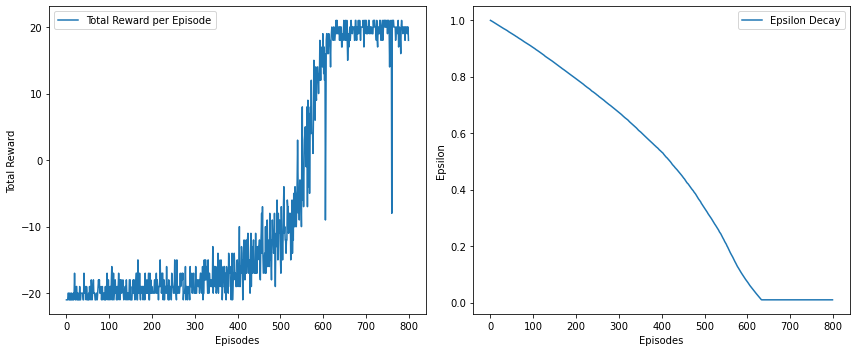

In [4]:
# ---- Plot Results ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_history, label="Total Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilon_history, label="Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
# ---- Evaluation Function ----
def evaluate_model(model, env, num_episodes=10):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    total_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state)
        total_reward = 0
        
        done = False
        while not done:
            # Select the action with the highest Q-value (greedy)
            with torch.no_grad():
                q_values = model(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
                action = torch.argmax(q_values).item()
            
            # Take action and get next state
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = np.array(next_state)
            
            state = next_state
            total_reward += reward
        
        total_rewards.append(total_reward)
        print(f"Episode {episode + 1} | Total Reward: {total_reward}")
    
    # Compute and print the average reward across all episodes
    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
    return avg_reward

In [5]:
# ---- After Training ----
print("\nEvaluating the agent for 10 episodes...")
evaluate_model(dqn, env, num_episodes=10)


Evaluating the agent for 10 episodes...
Episode 1 | Total Reward: 21.0
Episode 2 | Total Reward: 21.0
Episode 3 | Total Reward: 20.0
Episode 4 | Total Reward: 21.0
Episode 5 | Total Reward: 21.0
Episode 6 | Total Reward: 21.0
Episode 7 | Total Reward: 21.0
Episode 8 | Total Reward: 20.0
Episode 9 | Total Reward: 20.0
Episode 10 | Total Reward: 21.0
Average Reward over 10 episodes: 20.70


20.7

In [13]:
# ---- Save Model Weights ----
torch.save(dqn.state_dict(), 'dqn_weights.pth')
print("Model weights saved successfully.")

Model weights saved successfully.


## Dueling DQN to solve Atari Pong

In [3]:
GAMMA = 0.99 
LR_START = 1e-4
LR_END = 1e-6  
BUFFER_SIZE = 100_000
BATCH_SIZE = 32
EPSILON_START = 1.0
EPSILON_END = 0.01 
EPSILON_DECAY = 1000000
TARGET_UPDATE = 500  
TRAIN_EVERY = 10  
TRAIN_EPOCHS = 4  
MAX_TIMESTEPS = 5000000 
MAX_EPISODES = 800

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

class DDQN(nn.Module):
    def __init__(self, action_dim):
        super(DDQN, self).__init__()

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)

        self.value_stream = nn.Linear(512, 1)
        self.advantage_stream = nn.Linear(512, action_dim) 

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.orthogonal_(m.weight, gain=1.0)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        value = self.value_stream(x) 
        advantage = self.advantage_stream(x)
        
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

def decay_epsilon(epsilon, step_count, epsilon_start, epsilon_end, epsilon_decay):
    return max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (step_count / epsilon_decay))

def get_lr(epoch, total_epochs, lr_start, lr_end):
    return lr_start - (lr_start - lr_end) * (epoch / total_epochs)

def train(model, target_model, optimizer, replay_buffer):
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = replay_buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    loss = F.smooth_l1_loss(q_values, target_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

env = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")
env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
env = gym.wrappers.FrameStack(env, 4) 

action_dim = env.action_space.n
ddqn = DDQN(action_dim).to(device)
target_ddqn = DDQN(action_dim).to(device)
target_ddqn.load_state_dict(ddqn.state_dict())

optimizer = optim.Adam(ddqn.parameters(), lr=LR_START)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

epsilon = EPSILON_START
step_count = 0
total_timesteps = 0
reward_history = []
epsilon_history = []
total_steps = 0 
episode_count = 0
start_time = time.time()

for episode in range(MAX_TIMESTEPS):
    state, _ = env.reset()
    state = np.array(state)
    total_reward = 0
    episode_count += 1

    for step in range(MAX_TIMESTEPS):
        total_timesteps += 1
        total_steps += 1 
        epsilon = decay_epsilon(epsilon, total_timesteps, EPSILON_START, EPSILON_END, EPSILON_DECAY)

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = ddqn(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
                action = torch.argmax(q_values).item()

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.array(next_state)

        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if total_timesteps % TRAIN_EVERY == 0:
            for _ in range(TRAIN_EPOCHS):
                train(ddqn, target_ddqn, optimizer, replay_buffer)

        if total_timesteps % TARGET_UPDATE == 0:
            target_ddqn.load_state_dict(ddqn.state_dict())

        if done or truncated:
            break

    reward_history.append(total_reward)
    epsilon_history.append(epsilon)

    print(f"Episode {episode_count} | Reward: {total_reward} | Epsilon: {epsilon:.3f} | Total Steps: {total_steps}")

    if np.mean(reward_history[-100:]) >= 15:
        print(f"Converged! Reward 15 reached in {episode_count} episodes.")

    if episode_count == MAX_EPISODES:
        break;


end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Total Episodes: {episode_count} | Total Steps: {total_steps}")

Device: cuda


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Episode 1 | Reward: -19.0 | Epsilon: 0.999 | Total Steps: 1005
Episode 2 | Reward: -21.0 | Epsilon: 0.998 | Total Steps: 1963
Episode 3 | Reward: -21.0 | Epsilon: 0.997 | Total Steps: 2753
Episode 4 | Reward: -20.0 | Epsilon: 0.996 | Total Steps: 3652
Episode 5 | Reward: -21.0 | Epsilon: 0.996 | Total Steps: 4412
Episode 6 | Reward: -21.0 | Epsilon: 0.995 | Total Steps: 5171
Episode 7 | Reward: -21.0 | Epsilon: 0.994 | Total Steps: 6038
Episode 8 | Reward: -20.0 | Epsilon: 0.993 | Total Steps: 6902
Episode 9 | Reward: -20.0 | Epsilon: 0.992 | Total Steps: 7938
Episode 10 | Reward: -21.0 | Epsilon: 0.991 | Total Steps: 8994
Episode 11 | Reward: -20.0 | Epsilon: 0.990 | Total Steps: 10042
Episode 12 | Reward: -21.0 | Epsilon: 0.989 | Total Steps: 10891
Episode 13 | Reward: -21.0 | Epsilon: 0.988 | Total Steps: 11698
Episode 14 | Reward: -20.0 | Epsilon: 0.987 | Total Steps: 12651
Episode 15 | Reward: -21.0 | Epsilon: 0.987 | Total Steps: 13432
Episode 16 | Reward: -20.0 | Epsilon: 0.986 

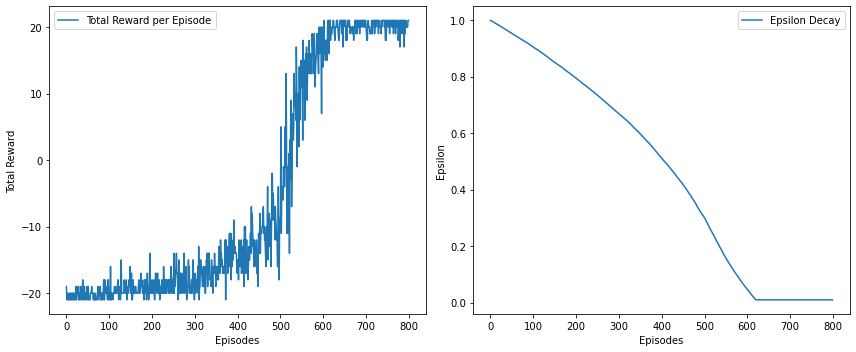

In [4]:
# ---- Plot Results ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_history, label="Total Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilon_history, label="Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
print("\nEvaluating the agent for 10 episodes...")
evaluate_model(ddqn, env, num_episodes=10)


Evaluating the agent for 10 episodes...
Episode 1 | Total Reward: 21.0
Episode 2 | Total Reward: 21.0
Episode 3 | Total Reward: 21.0
Episode 4 | Total Reward: 21.0
Episode 5 | Total Reward: 21.0
Episode 6 | Total Reward: 21.0
Episode 7 | Total Reward: 21.0
Episode 8 | Total Reward: 21.0
Episode 9 | Total Reward: 21.0
Episode 10 | Total Reward: 21.0
Average Reward over 10 episodes: 21.00


21.0

In [2]:
# ---- Save Model Weights ----
torch.save(ddqn.state_dict(), 'dqn_weights.pth')
print("Model weights saved successfully.")

Model weights saved successfully.
